In [62]:
import glob
import os.path as osp
import random
import numpy as np
import json

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [63]:
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

In [64]:
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
        'train':transforms.Compose([
            transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ]),
        'val':transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
    }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

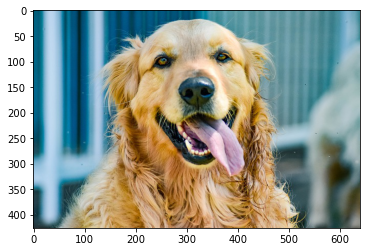

In [65]:
img_file_path='./data/goldenretriever-3724972_640.jpg'
img=Image.open(img_file_path)

plt.imshow(img)
plt.show()

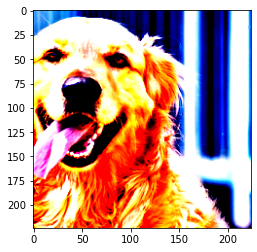

In [66]:
size=224
mean=(0.286,0.456,0.406)
std=(0.229,0.224,0.225)

transform=ImageTransform(size,mean,std)
img_transformed=transform(img,phase="train")

img_transformed=img_transformed.numpy().transpose(1,2,0)
img_transformed=np.clip(img_transformed,0,1)

plt.imshow(img_transformed)
plt.show()

In [67]:
def make_datapath_list(phase="train"):
    root="./data/hymenoptera_data/"
    target=osp.join(root+phase+'/**/*.jpg')
    
    path_list=[path for path in glob.glob(target)]

    return path_list

In [68]:
train_list=make_datapath_list()
val_list=make_datapath_list("val")

In [69]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list,transform=None,phase="train"):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path=self.file_list[index]
        img=Image.open(img_path)

        img_transformed=self.transform(img,self.phase)

        if self.phase=="train":
            label=img_path[30:34]
        elif self.phase=="val":
            label=img_path[28:32]

        if label=="ants":
            label=0
        elif label=="bees":
            label=1

        return img_transformed,label

In [70]:
train_dataset=HymenopteraDataset(
    file_list=train_list,transform=ImageTransform(size,mean,std)
)
val_dataset=HymenopteraDataset(
    file_list=val_list,transform=ImageTransform(size,mean,std),phase="val"
)

In [71]:
print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1])

torch.Size([3, 224, 224])
1


In [72]:
batch_size=32
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

dataloaders_dict={"train":train_dataloader,"val":val_dataloader}

batch_iterator=iter(dataloaders_dict["train"])
inputs,labels=next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1])


In [73]:
net=models.vgg16(pretrained=True)
net.classifier[6]=nn.Linear(in_features=4096,out_features=2)
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [74]:
criterion=nn.CrossEntropyLoss()

In [75]:
params_to_update=[]
update_param_names=["classifier.6.weight","classifier.6.bias"]

for name,param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad=True
        params_to_update.append(param)
        print(name)
    else: param.requires_grad=False

print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0086,  0.0088, -0.0079,  ...,  0.0089,  0.0061,  0.0013],
        [-0.0094, -0.0024,  0.0099,  ...,  0.0064,  0.0140,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([0.0121, 0.0133], requires_grad=True)]


In [76]:
optimizer=optim.SGD(params=params_to_update,lr=0.001,momentum=0.9)

In [103]:
def train_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train','val']:
            if phase=="Train":
                net.train()
            else: 
                net.eval()

        epoch_loss=0.0
        epoch_corrects=0
        if epoch==0 and phase=="train":
            continue

        for inputs,labels in tqdm(dataloaders_dict[phase]):
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                outputs=net(inputs)
                loss =criterion(outputs,labels)
                _,preds=torch.max(outputs,1)

                if phase=="train":
                    loss.backward()
                    optimizer.step()
                
                epoch_loss+=loss.item()*inputs.size(0)
                epoch_corrects+=torch.sum(preds==labels.data)

        epoch_loss=epoch_loss/len(dataloaders_dict[phase].dataset)
        epoch_accuracy=epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

        print(f"[{phase}]{epoch_loss},{epoch_accuracy}")

In [104]:

num_epochs=2
train_model(net,dataloaders_dict,criterion,optimizer,num_epochs=2)

Epoch 1/2


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


[val]0.8742959764268663,0.40522875816993464
Epoch 2/2


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

[val]0.8742959425340291,0.40522875816993464
